In [12]:
import torch
import torch.nn as nn 
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


## **Model Architecture**

In [41]:
# Simple 3 layer covolution model 
class CNN_model(nn.Module):
    def __init__(self, in_channel,num_classes):
        super().__init__()
        
        # Convolution blocks
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channel, 16, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 64, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1)
        )
        
        # NN block
        self.fully_connected = nn.Sequential(
            nn.Linear(16*16*128, 256),     # 32768 -> 256
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),     # 32768 -> 256
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes),             # Output layer (9 waste categories)
        )
    def forward(self,x):
        X = self.feature_extractor(x)
        X = torch.flatten(X,1)
        X = self.fully_connected(X)
        
        return X
        
        

## **Data Loaders**

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import random
from collections import defaultdict

# Define standard transform for basic transformations
transform_standard = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def rotate_90s():
    return transforms.Lambda(lambda img: img.rotate(random.choice([90, 180, 270])))

# Define augmentation transforms
augmentation_transforms = [
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        rotate_90s(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        rotate_90s(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        rotate_90s(),
        transforms.RandomAffine(degrees=10, translate=(0.01, 0.01), scale=(0.95, 1.05)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        rotate_90s(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
]


class SimpleDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        return self.transform(img), label


class BalancedAugmentedDataset(Dataset):
    """
    Smart dataset that applies augmentations only to underrepresented classes.
    Ensures all original samples are kept and augmentations are added strategically.
    """
    def __init__(self, dataset, indices, transform=None, target_samples_per_class=None):
        """
        Args:
            dataset: Original ImageFolder dataset
            indices: Indices for this split (train/val/test)
            transform: Transform to apply to original samples
            target_samples_per_class: Target number of samples per class (uses mean if None)
        """
        self.dataset = dataset
        self.base_transform = transform if transform else transform_standard
        
        # Group indices by class
        self.class_to_indices = defaultdict(list)
        for idx in indices:
            _, label = dataset[idx]
            self.class_to_indices[label].append(idx)
        
        # Calculate target samples per class (mean if not specified)
        if target_samples_per_class is None:
            samples_per_class = [len(idxs) for idxs in self.class_to_indices.values()]
            self.target_samples = int(sum(samples_per_class) / len(samples_per_class))
        else:
            self.target_samples = target_samples_per_class
        
        print(f"\nTarget samples per class: {self.target_samples}")
        
        # Build the augmented dataset structure
        self.samples = []  # List of (original_idx, aug_transform_idx, label)
        
        for label, original_indices in self.class_to_indices.items():
            num_original = len(original_indices)
            
            # Always add all original samples first (aug_transform_idx = -1 means no augmentation)
            for idx in original_indices:
                self.samples.append((idx, -1, label))
            
            # Calculate how many augmentations we need
            if num_original < self.target_samples:
                num_augmentations_needed = self.target_samples - num_original
                
                print(f"Class {label}: {num_original} original samples, "
                      f"adding {num_augmentations_needed} augmentations")
                
                # Cycle through original images and augmentation transforms
                aug_count = 0
                while aug_count < num_augmentations_needed:
                    for idx in original_indices:
                        if aug_count >= num_augmentations_needed:
                            break
                        
                        # Select augmentation transform (cycle through available transforms)
                        aug_transform_idx = aug_count % len(augmentation_transforms)
                        self.samples.append((idx, aug_transform_idx, label))
                        aug_count += 1
            else:
                print(f"Class {label}: {num_original} original samples (above target, no augmentation needed)")
        
        print(f"\nTotal dataset size: {len(self.samples)}")
        print(f"  - Original samples: {len(indices)}")
        print(f"  - Augmented samples: {len(self.samples) - len(indices)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        original_idx, aug_transform_idx, label = self.samples[idx]
        img, _ = self.dataset[original_idx]
        
        # Apply augmentation if specified, otherwise use base transform
        if aug_transform_idx == -1:
            # Original sample with base transform
            return self.base_transform(img), label
        else:
            # Augmented sample
            return augmentation_transforms[aug_transform_idx](img), label

        

In [15]:
# Path to the RealWaste dataset
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"  # Update if needed

# Load the original dataset without transforms (we'll apply them in the wrapper)
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Get dataset size
dataset_size = len(dataset)
num_classes = len(dataset.classes)

print(f"Original dataset size: {dataset_size}")
print(f"Class names: {dataset.classes}")


# Calculate split sizes (70% train, 15% validation, 15% test)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Create indices for the splits
indices = list(range(dataset_size))
random.seed(42)  # For reproducibility
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create base dataset splits
train_dataset = BalancedAugmentedDataset(
    dataset, 
    train_indices, 
    transform=transform_standard,
    target_samples_per_class=None  # Will use mean, or specify a number like 1000
)

val_dataset = SimpleDataset(dataset, val_indices, transform_standard)
test_dataset = SimpleDataset(dataset, test_indices, transform_standard)

# Augment only the training set (4 augmentations per image + original)


# Print split information
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Original dataset size: 4752
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

Target samples per class: 369
Class 5: 349 original samples, adding 20 augmentations
Class 0: 332 original samples, adding 37 augmentations
Class 6: 637 original samples (above target, no augmentation needed)
Class 1: 273 original samples, adding 96 augmentations
Class 3: 544 original samples (above target, no augmentation needed)
Class 7: 234 original samples, adding 135 augmentations
Class 8: 315 original samples, adding 54 augmentations
Class 2: 291 original samples, adding 78 augmentations
Class 4: 351 original samples, adding 18 augmentations

Total dataset size: 3764
  - Original samples: 3326
  - Augmented samples: 438
Training samples: 3764
Validation samples: 712
Test samples: 714


Saving test dataset for later use

In [16]:
import os
import shutil

# Destination for saved test images (change if needed)
dest_root = "/kaggle/working/test_dataset"
os.makedirs(dest_root, exist_ok=True)

copied = 0
for idx in test_indices:
    src_path, class_idx = dataset.samples[idx]   # ImageFolder stores (path, class_idx)
    class_name = dataset.classes[class_idx]
    dst_class_dir = os.path.join(dest_root, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

    base_name = os.path.basename(src_path)
    dst_path = os.path.join(dst_class_dir, base_name)

    # avoid overwrite
    if os.path.exists(dst_path):
        name, ext = os.path.splitext(base_name)
        dst_path = os.path.join(dst_class_dir, f"{name}_{idx}{ext}")

    shutil.copy2(src_path, dst_path)
    copied += 1

print(f"Saved {copied} test images to: {dest_root}")

# Create a zip archive next to the folder (result: e:\Projects\CNN\test_dataset.zip)
archive_base = os.path.join(os.path.dirname(dest_root), os.path.basename(dest_root))
archive_path = shutil.make_archive(archive_base, 'zip', root_dir=dest_root)
print(f"Created zip archive: {archive_path}")

Saved 714 test images to: /kaggle/working/test_dataset
Created zip archive: /kaggle/working/test_dataset.zip


In [17]:
def count_samples_per_class(dataset, num_classes):
    """Count the number of samples per class in a dataset"""
    class_counts = {i: 0 for i in range(num_classes)}
    
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        label_idx = label.item() if isinstance(label, torch.Tensor) else label
        class_counts[label_idx] += 1
    
    print("\n" + "="*50)
    print("Class distribution:")
    print("="*50)
    print(f"{'Class':<10} {'Count':<10} {'Percentage':<10}")
    print("-" * 50)
    
    total_samples = len(dataset)
    for class_idx, count in class_counts.items():
        percentage = (count / total_samples) * 100
        print(f"{class_idx:<10} {count:<10} {percentage:.2f}%")
    
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    print("-" * 50)
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    print("="*50)
    
    return class_counts

# Analyze the balanced training dataset
train_class_counts = count_samples_per_class(train_dataset, len(dataset.classes))



Class distribution:
Class      Count      Percentage
--------------------------------------------------
0          369        9.80%
1          369        9.80%
2          369        9.80%
3          544        14.45%
4          369        9.80%
5          369        9.80%
6          637        16.92%
7          369        9.80%
8          369        9.80%
--------------------------------------------------
Imbalance ratio (max/min): 1.73


Creating the Dataloaders

In [18]:
# Create data loaders
batch_size = 16  # Smaller batch size for larger images
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Visualization of a batch

Checking training data...
Batch shape: torch.Size([16, 3, 128, 128])
Labels shape: torch.Size([16])


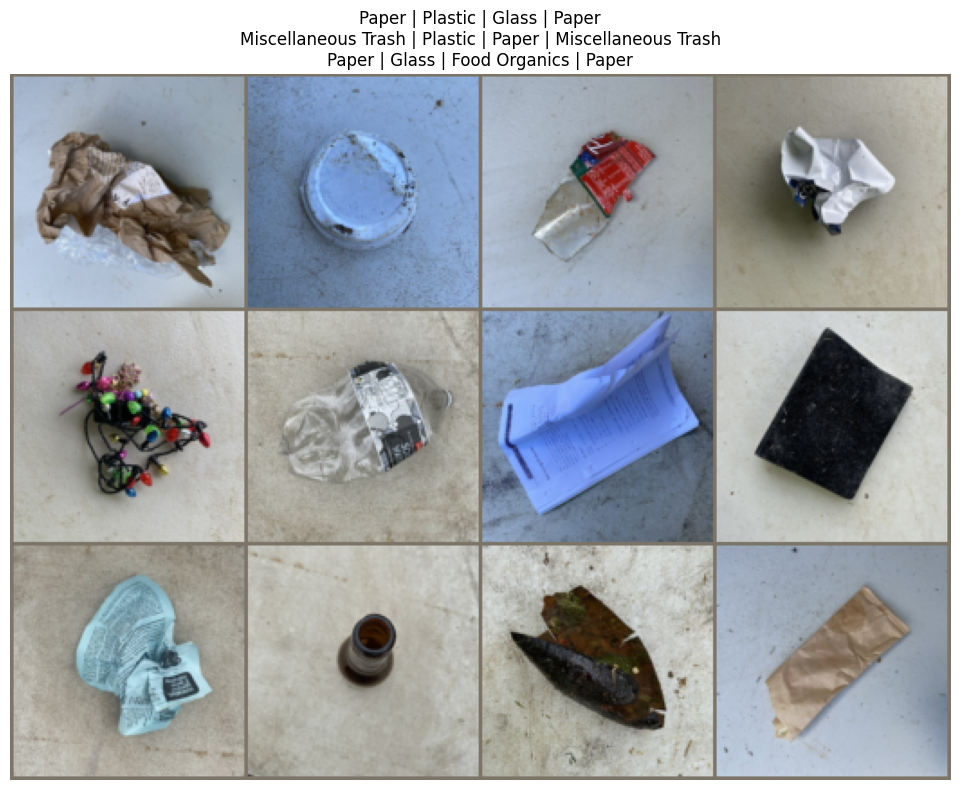

Has NaN: False
Has Inf: False
Min value: -2.1179039478302
Max value: 2.640000104904175

Checking validation data...
Batch shape: torch.Size([16, 3, 128, 128])
Labels shape: torch.Size([16])


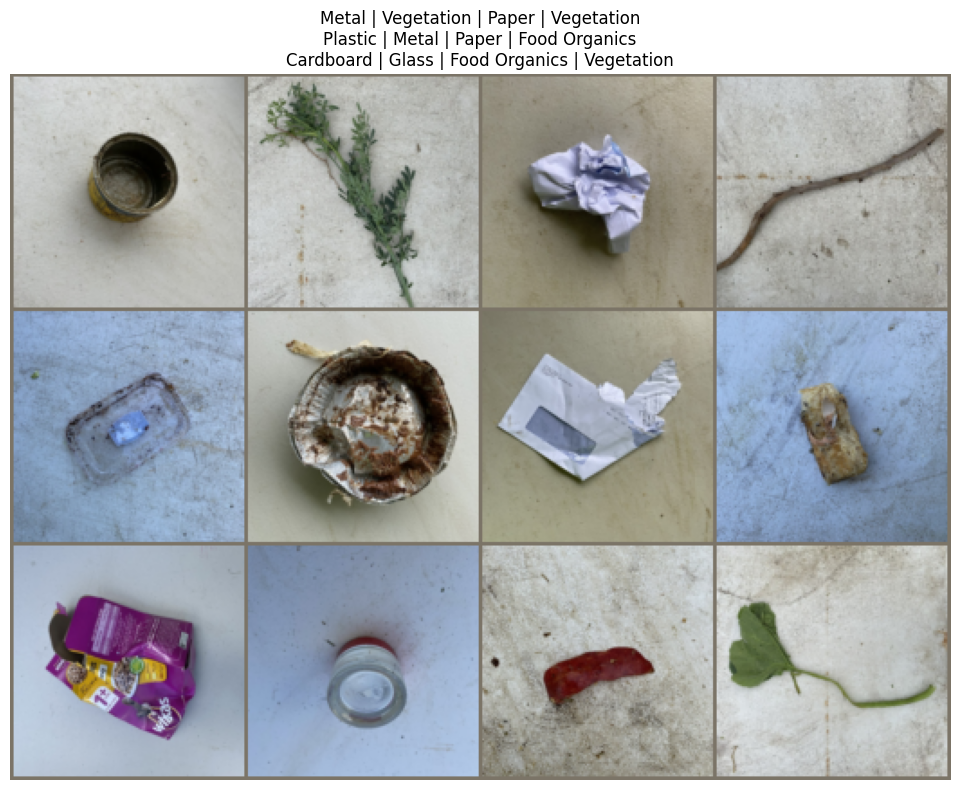

Has NaN: False
Has Inf: False
Min value: -2.1007792949676514
Max value: 2.6051416397094727


True

In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def show_batch(dataloader, classes, num_images=12):
    """
    Display a batch of images with their labels from a dataloader
    
    Args:
        dataloader: PyTorch dataloader to get images from
        classes: List of class names
        num_images: Maximum number of images to display
    """
    # Get a batch of training data
    images, labels = next(iter(dataloader))
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Convert images back to a displayable format
    images = images[:num_images]  # Take only the first num_images
    labels = labels[:num_images]
    
    # Unnormalize the images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Create a grid of images
    img_grid = make_grid(images, nrow=4)
    img_grid = img_grid.numpy().transpose((1, 2, 0))
    
    # Unnormalize
    img_grid = std * img_grid + mean
    img_grid = np.clip(img_grid, 0, 1)
    
    # Display the images
    plt.figure(figsize=(12, 8))
    plt.imshow(img_grid)
    plt.axis('off')
    
    # Add labels as titles - fix the list issue
    # Convert each label tensor to its corresponding class name
    title_list = []
    for i in range(len(labels)):
        # Make sure to get the integer value from the tensor
        class_idx = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        title_list.append(f"{classes[class_idx]}")
    
    # Group titles into rows of 4 for display
    title_rows = []
    for i in range(0, len(title_list), 4):
        row = title_list[i:i+4]
        title_rows.append(" | ".join(row))
    
    # Join all rows with newlines
    title = "\n".join(title_rows)
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Check if any of the tensor values are NaN or Inf
    print(f"Has NaN: {torch.isnan(images).any()}")
    print(f"Has Inf: {torch.isinf(images).any()}")
    print(f"Min value: {images.min()}")
    print(f"Max value: {images.max()}")
    
    return True

# Test the train loader
print("Checking training data...")
show_batch(train_loader, dataset.classes)

# Test the validation loader
print("\nChecking validation data...")
show_batch(val_loader, dataset.classes)

## **Training**

In [20]:
import time 
import os
from tqdm import tqdm

def Train(device, model, epochs, optimizer, scheduler, save_dir="/kaggle/working/models", name="", batch_size=None):
    
    os.makedirs(save_dir, exist_ok=True)

    loss_fn = nn.CrossEntropyLoss()
    
    # Optional: Add learning rate scheduler for better convergence
    
    EPOCHS = epochs
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    best_val_loss = float('inf')
    best_model_path = os.path.join(save_dir, f"best_model_{name}.pth")
    last_model_path = os.path.join(save_dir, f"last_model_{name}.pth")

    for epoch in range(EPOCHS):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        print(f"Epoch {epoch+1}/{EPOCHS} [Train]")
        for images, labels in tqdm(train_loader):
            # Move data to device
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            # Zero gradients
            optimizer.zero_grad(set_to_none=True)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            # Track metrics (using your approach)
            train_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            train_correct += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_loss /= len(train_dataset)
        train_acc = train_correct / len(train_dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        print(f"Epoch {epoch+1}/{EPOCHS} [Val]")
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                # Move data to device
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                # Track metrics
                val_loss += loss.item() * images.size(0)
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate validation metrics
        val_loss /= len(val_dataset)
        val_acc = val_correct / len(val_dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Save the latest model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses,
            'train_acc': train_accs,
            'val_loss': val_losses,
            'val_acc': val_accs,
            'current_lr': optimizer.param_groups[0]['lr']
        }, last_model_path)
        
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_losses,
                'train_acc': train_accs,
                'val_loss': val_losses,
                'val_acc': val_accs,
                'best_val_loss': best_val_loss,
                'current_lr': optimizer.param_groups[0]['lr']
            }, best_model_path)
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
        
        # Calculate time taken for epoch
        epoch_time = time.time() - start_time
        
        # Print epoch summary (using your format)
        print(f'Epoch: {epoch+1}/{EPOCHS}, '
              f'Time: {epoch_time:.2f}s, '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    print(f"Training completed. Best validation loss: {best_val_loss:.4f}")
    print(f"Best model saved to {best_model_path}")
    print(f"Last model saved to {last_model_path}")
    
    # Return training history
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }
    
    return history, model

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

train_hist = dict()

cuda


## CNN Model - AdamW

In [42]:
model_Adm = CNN_model(in_channel=3, num_classes=num_classes).to(device)

# Adam with weight decay
optimizer = optim.Adam(  
    model_Adm.parameters(), 
    lr=8e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    )

name = "Adam"

Epoch 1/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.77it/s]


Epoch 1/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.79it/s]


Saved new best model with validation loss: 1.4108
Epoch: 1/20, Time: 11.84s, Train Loss: 1.8192, Train Acc: 0.3544, Val Loss: 1.4108, Val Acc: 0.5534, LR: 0.000800
Epoch 2/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 25.03it/s]


Epoch 2/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.62it/s]


Saved new best model with validation loss: 1.2621
Epoch: 2/20, Time: 11.80s, Train Loss: 1.5599, Train Acc: 0.4466, Val Loss: 1.2621, Val Acc: 0.5913, LR: 0.000800
Epoch 3/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.48it/s]


Epoch 3/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.33it/s]


Saved new best model with validation loss: 1.1428
Epoch: 3/20, Time: 12.00s, Train Loss: 1.4572, Train Acc: 0.4883, Val Loss: 1.1428, Val Acc: 0.6348, LR: 0.000800
Epoch 4/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.73it/s]


Epoch 4/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.27it/s]


Saved new best model with validation loss: 1.0423
Epoch: 4/20, Time: 11.85s, Train Loss: 1.3528, Train Acc: 0.5231, Val Loss: 1.0423, Val Acc: 0.6334, LR: 0.000800
Epoch 5/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.58it/s]


Epoch 5/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.44it/s]


Saved new best model with validation loss: 0.9774
Epoch: 5/20, Time: 11.88s, Train Loss: 1.3044, Train Acc: 0.5420, Val Loss: 0.9774, Val Acc: 0.6784, LR: 0.000800
Epoch 6/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.95it/s]


Epoch 6/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.38it/s]


Epoch: 6/20, Time: 11.48s, Train Loss: 1.2739, Train Acc: 0.5523, Val Loss: 0.9971, Val Acc: 0.6475, LR: 0.000800
Epoch 7/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.99it/s]


Epoch 7/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.96it/s]


Saved new best model with validation loss: 0.9287
Epoch: 7/20, Time: 11.77s, Train Loss: 1.2099, Train Acc: 0.5731, Val Loss: 0.9287, Val Acc: 0.6868, LR: 0.000800
Epoch 8/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.86it/s]


Epoch 8/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 27.13it/s]


Epoch: 8/20, Time: 11.45s, Train Loss: 1.1649, Train Acc: 0.5959, Val Loss: 0.9622, Val Acc: 0.6587, LR: 0.000800
Epoch 9/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.95it/s]


Epoch 9/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 27.21it/s]


Saved new best model with validation loss: 0.8941
Epoch: 9/20, Time: 11.69s, Train Loss: 1.1479, Train Acc: 0.6033, Val Loss: 0.8941, Val Acc: 0.6798, LR: 0.000800
Epoch 10/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.71it/s]


Epoch 10/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.27it/s]


Epoch: 10/20, Time: 11.58s, Train Loss: 1.0973, Train Acc: 0.6219, Val Loss: 0.9042, Val Acc: 0.6882, LR: 0.000800
Epoch 11/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.94it/s]


Epoch 11/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.15it/s]


Saved new best model with validation loss: 0.8345
Epoch: 11/20, Time: 11.78s, Train Loss: 1.0498, Train Acc: 0.6296, Val Loss: 0.8345, Val Acc: 0.7051, LR: 0.000800
Epoch 12/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.78it/s]


Epoch 12/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.25it/s]


Epoch: 12/20, Time: 11.55s, Train Loss: 1.0217, Train Acc: 0.6464, Val Loss: 0.8473, Val Acc: 0.6826, LR: 0.000800
Epoch 13/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.92it/s]


Epoch 13/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.17it/s]


Epoch: 13/20, Time: 11.54s, Train Loss: 1.0006, Train Acc: 0.6541, Val Loss: 0.8622, Val Acc: 0.7008, LR: 0.000800
Epoch 14/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 25.22it/s]


Epoch 14/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.16it/s]


Saved new best model with validation loss: 0.8167
Epoch: 14/20, Time: 11.71s, Train Loss: 0.9345, Train Acc: 0.6854, Val Loss: 0.8167, Val Acc: 0.7177, LR: 0.000800
Epoch 15/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.96it/s]


Epoch 15/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.03it/s]


Saved new best model with validation loss: 0.8020
Epoch: 15/20, Time: 11.81s, Train Loss: 0.9008, Train Acc: 0.6985, Val Loss: 0.8020, Val Acc: 0.7022, LR: 0.000800
Epoch 16/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 25.14it/s]


Epoch 16/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.19it/s]


Saved new best model with validation loss: 0.7751
Epoch: 16/20, Time: 11.70s, Train Loss: 0.8632, Train Acc: 0.6995, Val Loss: 0.7751, Val Acc: 0.7149, LR: 0.000800
Epoch 17/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.93it/s]


Epoch 17/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.98it/s]


Epoch: 17/20, Time: 11.48s, Train Loss: 0.8462, Train Acc: 0.7101, Val Loss: 0.7868, Val Acc: 0.7233, LR: 0.000800
Epoch 18/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 25.00it/s]


Epoch 18/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.92it/s]


Epoch: 18/20, Time: 11.44s, Train Loss: 0.8155, Train Acc: 0.7205, Val Loss: 0.8384, Val Acc: 0.6994, LR: 0.000800
Epoch 19/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.43it/s]


Epoch 19/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.30it/s]


Epoch: 19/20, Time: 11.70s, Train Loss: 0.7718, Train Acc: 0.7487, Val Loss: 0.7775, Val Acc: 0.7275, LR: 0.000800
Epoch 20/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.90it/s]


Epoch 20/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.79it/s]


Epoch: 20/20, Time: 11.53s, Train Loss: 0.7383, Train Acc: 0.7577, Val Loss: 0.8082, Val Acc: 0.7233, LR: 0.000400
Training completed. Best validation loss: 0.7751
Best model saved to models/best_model_Adam.pth
Last model saved to models/last_model_Adam.pth


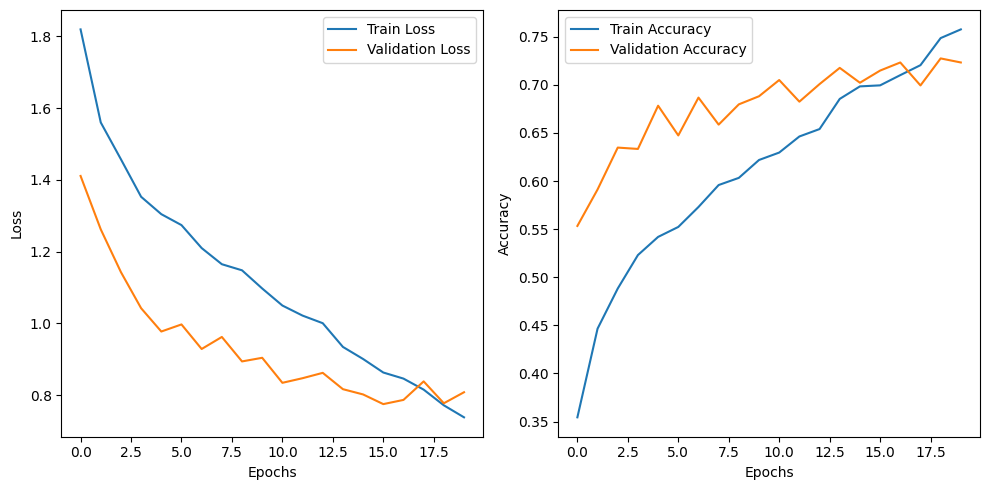

In [43]:
history, trained_model = Train(device, model_Adm, epochs=20,  optimizer=optimizer, scheduler=scheduler, name=name, save_dir="models")

train_hist["adam"] = history

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## CNN Model - SGD

In [44]:
model_SGD = CNN_model(in_channel=3, num_classes=num_classes).to(device)


# Standard SGD configuration
optimizer = optim.SGD(
        model_SGD.parameters(),
        lr=0.01,                # Initial learning rate
        weight_decay=1e-4       # L2 regularization to prevent overfitting
    )
    

# Learning rate scheduler (reduce LR when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,             # Multiply LR by 0.5 when plateauing
        patience=3              # Wait 4 epochs before reducing LR
    )

name = "SGD"

Epoch 1/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.35it/s]


Epoch 1/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.96it/s]


Saved new best model with validation loss: 1.5934
Epoch: 1/20, Time: 12.00s, Train Loss: 1.8677, Train Acc: 0.3252, Val Loss: 1.5934, Val Acc: 0.4635, LR: 0.010000
Epoch 2/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.02it/s]


Epoch 2/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.75it/s]


Saved new best model with validation loss: 1.5914
Epoch: 2/20, Time: 12.30s, Train Loss: 1.6313, Train Acc: 0.4198, Val Loss: 1.5914, Val Acc: 0.4551, LR: 0.010000
Epoch 3/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.60it/s]


Epoch 3/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.75it/s]


Saved new best model with validation loss: 1.2516
Epoch: 3/20, Time: 11.58s, Train Loss: 1.5249, Train Acc: 0.4647, Val Loss: 1.2516, Val Acc: 0.6067, LR: 0.010000
Epoch 4/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.14it/s]


Epoch 4/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.32it/s]


Epoch: 4/20, Time: 11.66s, Train Loss: 1.4592, Train Acc: 0.4830, Val Loss: 1.2682, Val Acc: 0.5534, LR: 0.010000
Epoch 5/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.19it/s]


Epoch 5/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.66it/s]


Saved new best model with validation loss: 1.2014
Epoch: 5/20, Time: 11.72s, Train Loss: 1.3869, Train Acc: 0.5173, Val Loss: 1.2014, Val Acc: 0.6166, LR: 0.010000
Epoch 6/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.92it/s]


Epoch 6/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.03it/s]


Saved new best model with validation loss: 1.1331
Epoch: 6/20, Time: 11.90s, Train Loss: 1.3242, Train Acc: 0.5260, Val Loss: 1.1331, Val Acc: 0.5969, LR: 0.010000
Epoch 7/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.50it/s]


Epoch 7/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.97it/s]


Saved new best model with validation loss: 1.0414
Epoch: 7/20, Time: 12.06s, Train Loss: 1.2840, Train Acc: 0.5502, Val Loss: 1.0414, Val Acc: 0.6362, LR: 0.010000
Epoch 8/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.11it/s]


Epoch 8/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.95it/s]


Epoch: 8/20, Time: 11.71s, Train Loss: 1.2421, Train Acc: 0.5675, Val Loss: 1.1138, Val Acc: 0.6194, LR: 0.010000
Epoch 9/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.40it/s]


Epoch 9/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.06it/s]


Epoch: 9/20, Time: 12.00s, Train Loss: 1.1795, Train Acc: 0.5940, Val Loss: 1.0429, Val Acc: 0.6587, LR: 0.010000
Epoch 10/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.56it/s]


Epoch 10/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.85it/s]


Saved new best model with validation loss: 0.9992
Epoch: 10/20, Time: 12.05s, Train Loss: 1.1515, Train Acc: 0.5986, Val Loss: 0.9992, Val Acc: 0.6517, LR: 0.010000
Epoch 11/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.28it/s]


Epoch 11/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.24it/s]


Epoch: 11/20, Time: 11.63s, Train Loss: 1.1228, Train Acc: 0.6052, Val Loss: 1.0268, Val Acc: 0.6475, LR: 0.010000
Epoch 12/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.07it/s]


Epoch 12/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.86it/s]


Epoch: 12/20, Time: 12.16s, Train Loss: 1.0803, Train Acc: 0.6326, Val Loss: 1.0595, Val Acc: 0.6348, LR: 0.010000
Epoch 13/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.42it/s]


Epoch 13/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.81it/s]


Saved new best model with validation loss: 0.9922
Epoch: 13/20, Time: 12.11s, Train Loss: 1.0261, Train Acc: 0.6517, Val Loss: 0.9922, Val Acc: 0.6517, LR: 0.010000
Epoch 14/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.85it/s]


Epoch 14/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.79it/s]


Epoch: 14/20, Time: 11.82s, Train Loss: 1.0028, Train Acc: 0.6517, Val Loss: 1.3134, Val Acc: 0.5407, LR: 0.010000
Epoch 15/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.33it/s]


Epoch 15/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.37it/s]


Epoch: 15/20, Time: 12.00s, Train Loss: 0.9701, Train Acc: 0.6738, Val Loss: 1.0151, Val Acc: 0.6419, LR: 0.010000
Epoch 16/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 23.49it/s]


Epoch 16/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.36it/s]


Epoch: 16/20, Time: 11.93s, Train Loss: 0.9744, Train Acc: 0.6674, Val Loss: 1.0181, Val Acc: 0.6433, LR: 0.010000
Epoch 17/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.82it/s]


Epoch 17/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.93it/s]


Saved new best model with validation loss: 0.8820
Epoch: 17/20, Time: 11.91s, Train Loss: 0.8919, Train Acc: 0.7022, Val Loss: 0.8820, Val Acc: 0.6980, LR: 0.010000
Epoch 18/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.88it/s]


Epoch 18/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.27it/s]


Epoch: 18/20, Time: 11.77s, Train Loss: 0.8551, Train Acc: 0.7117, Val Loss: 1.0558, Val Acc: 0.6320, LR: 0.010000
Epoch 19/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.83it/s]


Epoch 19/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.72it/s]


Epoch: 19/20, Time: 11.77s, Train Loss: 0.8594, Train Acc: 0.7160, Val Loss: 0.9797, Val Acc: 0.6601, LR: 0.010000
Epoch 20/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.58it/s]


Epoch 20/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.17it/s]


Epoch: 20/20, Time: 11.57s, Train Loss: 0.7736, Train Acc: 0.7359, Val Loss: 1.3745, Val Acc: 0.5267, LR: 0.010000
Training completed. Best validation loss: 0.8820
Best model saved to models/best_model_SGD.pth
Last model saved to models/last_model_SGD.pth


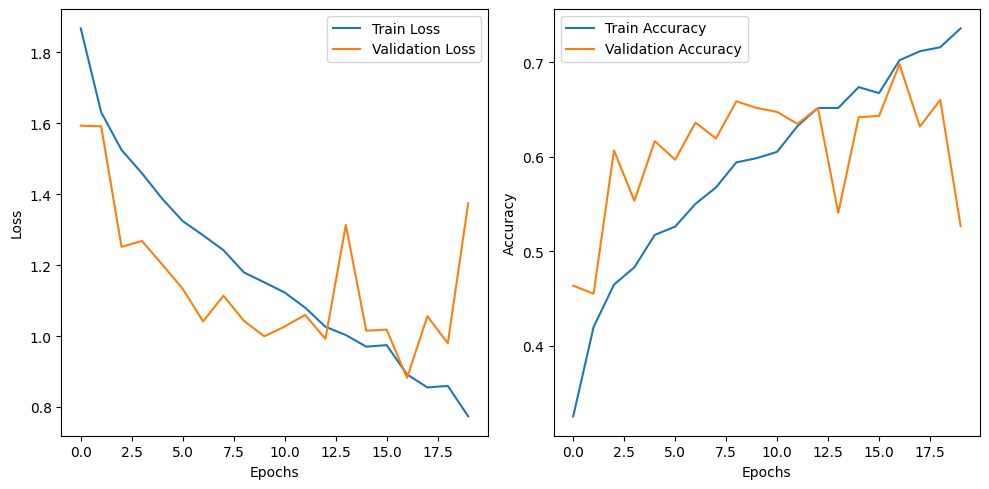

In [45]:
history, trained_model = Train(device, model_SGD, epochs=20,  optimizer=optimizer, scheduler=scheduler, name=name, save_dir="models")
train_hist["sgd"] = history

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## CNN Model - SGD with Momentum

In [46]:
model_SGDM = CNN_model(in_channel=3,num_classes=num_classes).to(device)


optimizer = optim.SGD(
        model_SGDM.parameters(),
        lr=0.01,                # Initial learning rate
        momentum=0.9,           # Momentum factor (0.9 is a common choice)
        nesterov=True,          # Using Nesterov accelerated gradient
        weight_decay=1e-4       # L2 regularization to prevent overfitting
    )
    
    # Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.3,             
        patience=3,             # Wait 5 epochs before reducing LR
    )

name = "SGDM"

Epoch 1/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.94it/s]


Epoch 1/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.97it/s]


Saved new best model with validation loss: 1.5037
Epoch: 1/20, Time: 11.90s, Train Loss: 1.8370, Train Acc: 0.3316, Val Loss: 1.5037, Val Acc: 0.4789, LR: 0.010000
Epoch 2/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.22it/s]


Epoch 2/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.84it/s]


Saved new best model with validation loss: 1.2925
Epoch: 2/20, Time: 11.98s, Train Loss: 1.6589, Train Acc: 0.4022, Val Loss: 1.2925, Val Acc: 0.5421, LR: 0.010000
Epoch 3/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.45it/s]


Epoch 3/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.71it/s]


Saved new best model with validation loss: 1.2411
Epoch: 3/20, Time: 11.86s, Train Loss: 1.5385, Train Acc: 0.4463, Val Loss: 1.2411, Val Acc: 0.5590, LR: 0.010000
Epoch 4/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.39it/s]


Epoch 4/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.72it/s]


Saved new best model with validation loss: 1.2028
Epoch: 4/20, Time: 11.88s, Train Loss: 1.4784, Train Acc: 0.4726, Val Loss: 1.2028, Val Acc: 0.5478, LR: 0.010000
Epoch 5/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.17it/s]


Epoch 5/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.57it/s]


Saved new best model with validation loss: 1.1220
Epoch: 5/20, Time: 12.04s, Train Loss: 1.4442, Train Acc: 0.4910, Val Loss: 1.1220, Val Acc: 0.5772, LR: 0.010000
Epoch 6/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.86it/s]


Epoch 6/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.19it/s]


Saved new best model with validation loss: 1.1137
Epoch: 6/20, Time: 11.67s, Train Loss: 1.3673, Train Acc: 0.5154, Val Loss: 1.1137, Val Acc: 0.5927, LR: 0.010000
Epoch 7/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.74it/s]


Epoch 7/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.27it/s]


Saved new best model with validation loss: 1.0443
Epoch: 7/20, Time: 11.69s, Train Loss: 1.3295, Train Acc: 0.5279, Val Loss: 1.0443, Val Acc: 0.6081, LR: 0.010000
Epoch 8/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.73it/s]


Epoch 8/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.33it/s]


Epoch: 8/20, Time: 11.54s, Train Loss: 1.2899, Train Acc: 0.5476, Val Loss: 1.0554, Val Acc: 0.6376, LR: 0.010000
Epoch 9/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.28it/s]


Epoch 9/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.53it/s]


Saved new best model with validation loss: 1.0068
Epoch: 9/20, Time: 11.81s, Train Loss: 1.2290, Train Acc: 0.5651, Val Loss: 1.0068, Val Acc: 0.6348, LR: 0.010000
Epoch 10/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.92it/s]


Epoch 10/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.70it/s]


Saved new best model with validation loss: 0.9792
Epoch: 10/20, Time: 11.67s, Train Loss: 1.1916, Train Acc: 0.5739, Val Loss: 0.9792, Val Acc: 0.6559, LR: 0.010000
Epoch 11/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.74it/s]


Epoch 11/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.20it/s]


Saved new best model with validation loss: 0.9755
Epoch: 11/20, Time: 12.08s, Train Loss: 1.1527, Train Acc: 0.5882, Val Loss: 0.9755, Val Acc: 0.6447, LR: 0.010000
Epoch 12/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.71it/s]


Epoch 12/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.02it/s]


Epoch: 12/20, Time: 11.97s, Train Loss: 1.1274, Train Acc: 0.6057, Val Loss: 1.0185, Val Acc: 0.6559, LR: 0.010000
Epoch 13/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.31it/s]


Epoch 13/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.22it/s]


Saved new best model with validation loss: 0.9388
Epoch: 13/20, Time: 11.86s, Train Loss: 1.1110, Train Acc: 0.6076, Val Loss: 0.9388, Val Acc: 0.6573, LR: 0.010000
Epoch 14/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.87it/s]


Epoch 14/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 25.64it/s]


Saved new best model with validation loss: 0.9002
Epoch: 14/20, Time: 12.06s, Train Loss: 1.0408, Train Acc: 0.6382, Val Loss: 0.9002, Val Acc: 0.6938, LR: 0.010000
Epoch 15/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.32it/s]


Epoch 15/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.63it/s]


Epoch: 15/20, Time: 11.61s, Train Loss: 1.0046, Train Acc: 0.6474, Val Loss: 0.9575, Val Acc: 0.6559, LR: 0.010000
Epoch 16/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.75it/s]


Epoch 16/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 24.75it/s]


Epoch: 16/20, Time: 11.56s, Train Loss: 0.9782, Train Acc: 0.6618, Val Loss: 0.9377, Val Acc: 0.6671, LR: 0.010000
Epoch 17/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 23.85it/s]


Epoch 17/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.42it/s]


Epoch: 17/20, Time: 11.80s, Train Loss: 0.9344, Train Acc: 0.6783, Val Loss: 0.9055, Val Acc: 0.6826, LR: 0.010000
Epoch 18/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.69it/s]


Epoch 18/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.10it/s]


Epoch: 18/20, Time: 11.49s, Train Loss: 0.9113, Train Acc: 0.6868, Val Loss: 0.9468, Val Acc: 0.6671, LR: 0.003000
Epoch 19/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.52it/s]


Epoch 19/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.03it/s]


Saved new best model with validation loss: 0.8463
Epoch: 19/20, Time: 11.78s, Train Loss: 0.8158, Train Acc: 0.7229, Val Loss: 0.8463, Val Acc: 0.6938, LR: 0.003000
Epoch 20/20 [Train]


100%|██████████| 236/236 [00:09<00:00, 24.95it/s]


Epoch 20/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 26.94it/s]


Saved new best model with validation loss: 0.8362
Epoch: 20/20, Time: 11.55s, Train Loss: 0.7773, Train Acc: 0.7333, Val Loss: 0.8362, Val Acc: 0.6938, LR: 0.003000
Training completed. Best validation loss: 0.8362
Best model saved to models/best_model_SGDM.pth
Last model saved to models/last_model_SGDM.pth


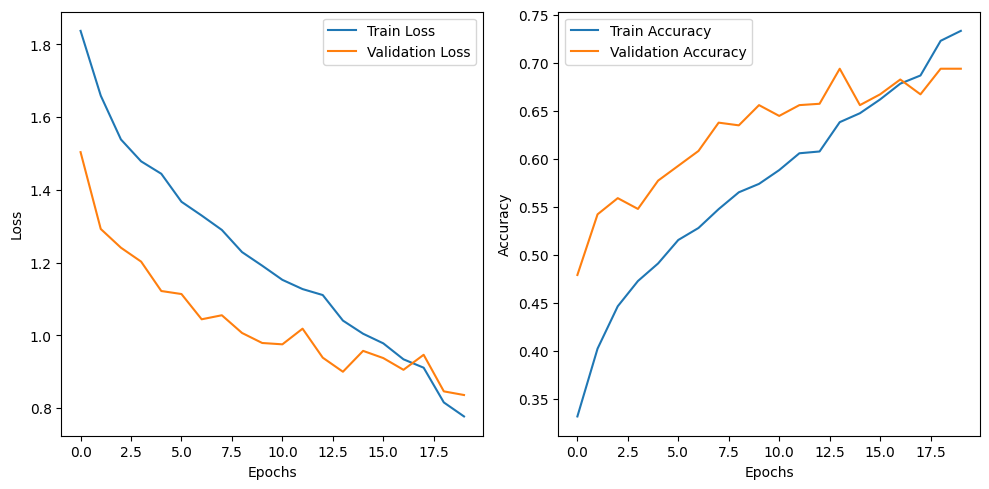

In [47]:
history, trained_model = Train(device, model_SGDM, epochs=20,  optimizer=optimizer, scheduler=scheduler, name=name, save_dir="models")
train_hist["sgdm"] = history


# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Resnet 50 Model

In [51]:
from torchvision import models

model_ft = models.resnet50(pretrained=True)

# Freeze earlier layers
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes) 

model_ft = model_ft.to(device)


# Only parameters of final layer are being optimized
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
name = "Resnet_50"

Epoch 1/20 [Train]


100%|██████████| 236/236 [00:11<00:00, 20.40it/s]


Epoch 1/20 [Val]


100%|██████████| 45/45 [00:02<00:00, 21.53it/s]


Saved new best model with validation loss: 1.0196
Epoch: 1/20, Time: 14.18s, Train Loss: 1.3844, Train Acc: 0.5239, Val Loss: 1.0196, Val Acc: 0.6587, LR: 0.000500
Epoch 2/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.50it/s]


Epoch 2/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 22.55it/s]


Saved new best model with validation loss: 0.9191
Epoch: 2/20, Time: 13.52s, Train Loss: 0.9724, Train Acc: 0.6666, Val Loss: 0.9191, Val Acc: 0.6728, LR: 0.000500
Epoch 3/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.85it/s]


Epoch 3/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 22.96it/s]


Saved new best model with validation loss: 0.8518
Epoch: 3/20, Time: 13.31s, Train Loss: 0.8798, Train Acc: 0.7059, Val Loss: 0.8518, Val Acc: 0.6882, LR: 0.000500
Epoch 4/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.76it/s]


Epoch 4/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 22.78it/s]


Epoch: 4/20, Time: 13.11s, Train Loss: 0.8155, Train Acc: 0.7144, Val Loss: 0.8890, Val Acc: 0.6756, LR: 0.000500
Epoch 5/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.96it/s]


Epoch 5/20 [Val]


100%|██████████| 45/45 [00:02<00:00, 21.84it/s]


Saved new best model with validation loss: 0.7802
Epoch: 5/20, Time: 13.36s, Train Loss: 0.7675, Train Acc: 0.7343, Val Loss: 0.7802, Val Acc: 0.7163, LR: 0.000500
Epoch 6/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.75it/s]


Epoch 6/20 [Val]


100%|██████████| 45/45 [00:02<00:00, 21.07it/s]


Epoch: 6/20, Time: 13.26s, Train Loss: 0.7323, Train Acc: 0.7505, Val Loss: 0.8225, Val Acc: 0.7037, LR: 0.000500
Epoch 7/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.83it/s]


Epoch 7/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 23.43it/s]


Epoch: 7/20, Time: 12.99s, Train Loss: 0.7245, Train Acc: 0.7508, Val Loss: 0.8855, Val Acc: 0.6728, LR: 0.000500
Epoch 8/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.36it/s]


Epoch 8/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 23.15it/s]


Epoch: 8/20, Time: 12.76s, Train Loss: 0.6950, Train Acc: 0.7606, Val Loss: 0.8338, Val Acc: 0.6980, LR: 0.000500
Epoch 9/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.87it/s]


Epoch 9/20 [Val]


100%|██████████| 45/45 [00:02<00:00, 21.61it/s]


Epoch: 9/20, Time: 13.13s, Train Loss: 0.6888, Train Acc: 0.7593, Val Loss: 0.8072, Val Acc: 0.7079, LR: 0.000500
Epoch 10/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.59it/s]


Epoch 10/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 22.55it/s]


Saved new best model with validation loss: 0.7549
Epoch: 10/20, Time: 13.40s, Train Loss: 0.6637, Train Acc: 0.7649, Val Loss: 0.7549, Val Acc: 0.7346, LR: 0.000500
Epoch 11/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.33it/s]


Epoch 11/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 22.66it/s]


Epoch: 11/20, Time: 12.81s, Train Loss: 0.6349, Train Acc: 0.7869, Val Loss: 0.7943, Val Acc: 0.7205, LR: 0.000500
Epoch 12/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.14it/s]


Epoch 12/20 [Val]


100%|██████████| 45/45 [00:02<00:00, 19.66it/s]


Epoch: 12/20, Time: 13.21s, Train Loss: 0.6358, Train Acc: 0.7798, Val Loss: 0.8036, Val Acc: 0.7233, LR: 0.000500
Epoch 13/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.16it/s]


Epoch 13/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 23.25it/s]


Epoch: 13/20, Time: 12.85s, Train Loss: 0.6054, Train Acc: 0.7938, Val Loss: 0.8245, Val Acc: 0.7051, LR: 0.000500
Epoch 14/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 21.83it/s]


Epoch 14/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 22.50it/s]


Epoch: 14/20, Time: 13.10s, Train Loss: 0.6244, Train Acc: 0.7779, Val Loss: 0.7888, Val Acc: 0.7163, LR: 0.000500
Epoch 15/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.21it/s]


Epoch 15/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 22.90it/s]


Saved new best model with validation loss: 0.7478
Epoch: 15/20, Time: 13.10s, Train Loss: 0.6014, Train Acc: 0.7914, Val Loss: 0.7478, Val Acc: 0.7289, LR: 0.000500
Epoch 16/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.28it/s]


Epoch 16/20 [Val]


100%|██████████| 45/45 [00:02<00:00, 22.36it/s]


Epoch: 16/20, Time: 12.90s, Train Loss: 0.6027, Train Acc: 0.7869, Val Loss: 0.7913, Val Acc: 0.7177, LR: 0.000500
Epoch 17/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.15it/s]


Epoch 17/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 23.35it/s]


Epoch: 17/20, Time: 12.87s, Train Loss: 0.6101, Train Acc: 0.7891, Val Loss: 0.7807, Val Acc: 0.7191, LR: 0.000500
Epoch 18/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.15it/s]


Epoch 18/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 23.42it/s]


Epoch: 18/20, Time: 12.87s, Train Loss: 0.6029, Train Acc: 0.7869, Val Loss: 0.7547, Val Acc: 0.7303, LR: 0.000500
Epoch 19/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.82it/s]


Epoch 19/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 23.49it/s]


Epoch: 19/20, Time: 12.53s, Train Loss: 0.5723, Train Acc: 0.7933, Val Loss: 0.7798, Val Acc: 0.7233, LR: 0.000500
Epoch 20/20 [Train]


100%|██████████| 236/236 [00:10<00:00, 22.78it/s]


Epoch 20/20 [Val]


100%|██████████| 45/45 [00:01<00:00, 23.95it/s]


Epoch: 20/20, Time: 12.49s, Train Loss: 0.5747, Train Acc: 0.7968, Val Loss: 0.7677, Val Acc: 0.7346, LR: 0.000500
Training completed. Best validation loss: 0.7478
Best model saved to models/best_model_Resnet_50.pth
Last model saved to models/last_model_Resnet_50.pth


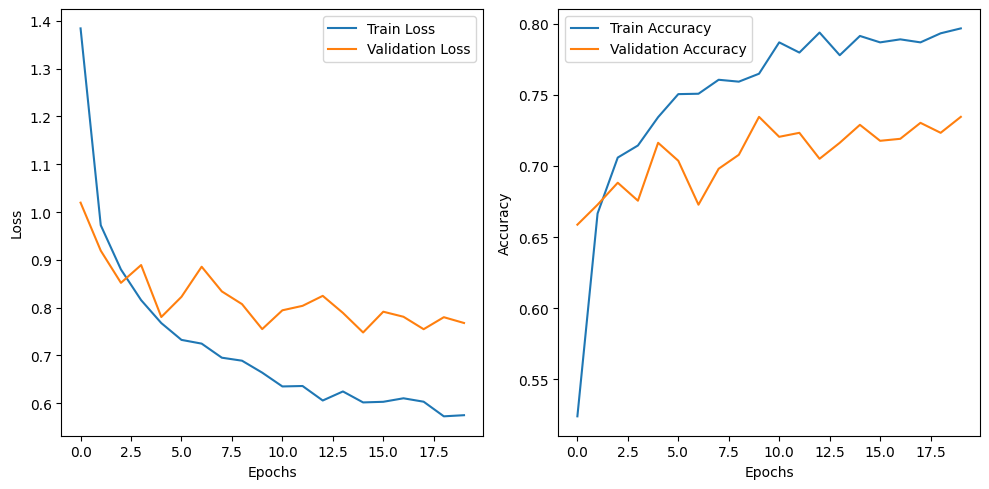

In [52]:
history, trained_model = Train(device, model_ft, epochs=20,  optimizer=optimizer_ft, scheduler=scheduler, name=name, save_dir="models")
train_hist["resnet"] = history

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
import json

def _json_default(o):
    if isinstance(o, np.ndarray):
        return o.tolist()
    if isinstance(o, (np.floating, np.integer)):
        return float(o)
    if isinstance(o, torch.Tensor):
        return o.detach().cpu().tolist()
    raise TypeError(f"Type {type(o)} not JSON serializable")

with open("models/training_histories.json", "w") as f:
    json.dump(train_hist, f, indent=2, default=_json_default)

In [55]:
!zip -r models.zip /kaggle/working/models

  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/models/best_model_Adam.pth (deflated 8%)
  adding: kaggle/working/models/last_model_SGDM.pth (deflated 7%)
  adding: kaggle/working/models/best_model_SGDM.pth (deflated 7%)
  adding: kaggle/working/models/last_model_SGD.pth (deflated 8%)
  adding: kaggle/working/models/best_model_Resnet_50.pth (deflated 7%)
  adding: kaggle/working/models/last_model_Adam.pth (deflated 8%)
  adding: kaggle/working/models/best_model_SGD.pth (deflated 8%)
  adding: kaggle/working/models/best_model_AdamW.pth (deflated 8%)
  adding: kaggle/working/models/training_histories.json (deflated 69%)
  adding: kaggle/working/models/last_model_Resnet_50.pth (deflated 7%)
  adding: kaggle/working/models/last_model_AdamW.pth (deflated 8%)
